Last edited: 07-14-2022

In [4]:
import time 

import numpy as np
import matplotlib.pyplot as plt

import scipy.special as special
from scipy.integrate import quad, dblquad, nquad
# from quadpy import quad
from scipy.signal import find_peaks, argrelmin
# from scipy.optimize import minimize

import chebpy

# import sympy as sp
# from functools import partial

# Eigenmodes in coaxial dielectric-loaded circular waveguides

First, we need the TEM field solutions for these things. 

* Reference 1: https://ieeexplore.ieee.org/abstract/document/1131658
    * This paper has the bonus of being solved in the bessel function basis, so that we can identify modes easily.


* Reference 2: https://ieeexplore.ieee.org/abstract/document/1133446
    * This paper solves modes in the hyperbolic function basis. This is required for the starting point of the cascaded result.



# Eigenmodes in axially cascaded coaxial dielectric-loaded circular waveguides

* Reference 3: https://ieeexplore.ieee.org/document/833726
    * This result basically solves eigenmodes in grooved cylinders (not helically grooved). It somewhat relies on this next reference


* Reference 4: https://ieeexplore.ieee.org/document/238522



<table>
    <td> <img src="SketchOfCavity1.png" alt="Drawing" style="width: 850px;"/> </td>
</table>

## Background for the case of perfect conductors with no open faces

Assume fields of the form

\begin{eqnarray}
  \left\{
  \begin{aligned}
    \vec{E}(\vec{r},t)&\;:=\; [\vec{e}_t(x,y) + \vec{e}_z (x,y)]e^{-j(-\beta z + \omega t)}\\
    \vec{H}(\vec{r},t)&\;:=\; [\vec{h}_t(x,y) + \vec{h}_z (x,y)]e^{-j(-\beta z + \omega t)}\\
  \end{aligned}
  \right.
\end{eqnarray}

and that everything in solid blue is a perfect conductor. Let 

$$ k^2 _c = \left(\frac{p'_{nm}}{a}\right) = k_0^2 - \beta ^2 = \omega^2 \mu\epsilon - \beta^2 $$

where $ \beta $ is the **propogation constant** in the transverse direction and $k_c$ is the **cutoff frequency**, a is the radius of boundary. The transverse solutions in region i are of the (orthonormal) form

\begin{eqnarray}
  \left\{
  \begin{aligned}
    \vec{E}^i_t(r,\phi)&\;:=\; \sum_{n=1,2,..} \left( A^i_n e^{-j\beta^i_n z} + B^i_n e^{j\beta^i_n z}\right) \vec{e}_{tn}(r,\phi)\\
    \vec{H}^i_t(r,\phi)&\;:=\; \sum_{n=1,2,..} \left( A^i_n e^{-j\beta^i_n z} - B^i_n e^{j\beta^i_n z}\right) \vec{h}_{tn}(r,\phi)
  \end{aligned}
  \right.
\end{eqnarray}

Note that n here is the index of a mode, whose relation to TE and TM is to be decided later. Define the wave impedance by 

\begin{eqnarray}
  Z &= 
  \left\{
  \begin{aligned}
    \frac{k}{\epsilon^i \mu^i} &\;=\; \frac{k}{k_0} \sqrt{\frac{\mu^i}{\epsilon^i}} & (TM) \\  
    \frac{\epsilon^i \mu^i}{k} &\;=\; \frac{k_0}{k} \sqrt{\frac{\mu^i}{\epsilon^i}} & (TE)
  \end{aligned}
  \right.
\end{eqnarray}


The transverse modes in region (i), in the Bessel basis are

\begin{eqnarray}
  \left\{
  \begin{aligned}
    \vec{e}^i_{tnml}(r,\phi)&\;=\; \frac{-j\omega^i_{nml}\mu^i}{{k^i}_{cnm}^2} F^i_{1nm}(r,\phi) \hat{r} + \frac{j\omega^i_{nml}\mu^i}{{k^i}_{cnm}} F^i_{2nm}(r,\phi) \hat{\phi} & (TE) \\
    \vec{h}^i_{tnml}(r,\phi)&\;=\; \frac{-j\beta^i_{nml}}{{k^i}_{cnm}} F^i_{2nm}(r,\phi) \hat{r} + \frac{-j\beta^i_{nml}}{{k^i}^2_{cnm}r} F^i_{1nm}(r,\phi)\hat{\phi} & (TE) \\
    \vec{e}^i_{tnml}(r,\phi)&\;=\; \frac{-j\beta^i_{nml}}{{k^i}_{cnm}} F^i_{2nm}(r,\phi) \hat{r} + \frac{-j\beta^i_{nml}}{{k^i}^2_{cnm}r} F^i_{1nm}(r,\phi)\hat{\phi} & (TM) \\
    \vec{h}^i_{tnml}(r,\phi)&\;=\; \frac{j\omega^i_{nml}\epsilon^i}{{k^i}_{cnm}^2} F^i_{1nm}(r,\phi) \hat{r} + \frac{-j\omega^i_{nml}\epsilon^i}{{k^i}_{cnm}} F^i_{2nm}(r,\phi) \hat{\phi} & (TM)
  \end{aligned}
  \right.
\end{eqnarray}

with

\begin{eqnarray}
  \left\{
  \begin{aligned}
    F_{1nm}(r,\phi)&\;:=\; \frac{n}{r}\sin(n\phi) J_n({k^i}_{cnm}r) \\
    F_{2nm}(r,\phi)&\;:=\; \cos(n\phi) J'_n({k^i}_{cnm}r)
  \end{aligned}
  \right.
\end{eqnarray}

Below is a class for generating the cylindrical eigenmodes

In [44]:
class T_modes():
    def __init__(self,Ttype,r_min,a,eps,mu,l):
        self.Ttype = Ttype
        self.r_min = r_min
        self.a = a
        self.eps = eps
        self.mu = mu
        self.l = l

    ############## Transverse fields #######################################
    def F1(self,r,phi,nn,mm,kc_mn):
        return [np.sin(nn*phi), -nn*special.jv(nn,kc_mn*r)/r]
        
    def F2(self,r,phi,nn,mm,kc_mn):
        return [np.cos(nn*phi), special.jvp(nn,kc_mn*r)]
    
    def T(self,query,omega,r,phi,z,nn,mm,ll):
        if self.Ttype=='TE':
            return self.TE(query,omega,r,phi,z,nn,mm,ll)
        else:
            return self.TM(query,omega,r,phi,z,nn,mm,ll)
        
    def norm_TE(self,omega,beta,kc_mn,nn,mm,ll):
        chi_nm = special.jnp_zeros(nn,mm)[mm-1]
        if nn==0: phi_int = 2*np.pi
        else: phi_int = np.pi
        
        r_int = .5*(self.a/chi_nm)**2 * (chi_nm**2 - nn**2) * special.jv(nn,chi_nm)**2
        amp = np.abs((omega*self.mu/kc_mn**2)*(beta/kc_mn**2))*kc_mn**2
        
        return (amp*phi_int*r_int)**(-1)
    
    def norm_TM(self,omega,beta,kc_mn,nn,mm,ll):
        chi_nm = special.jn_zeros(nn,mm)[mm-1]
        if nn==0: phi_int = 2*np.pi
        else: phi_int = np.pi
        
        r_int = .5*(self.a/chi_nm)**2 * (chi_nm**2) * special.jvp(nn,chi_nm)**2
        amp = np.abs((omega*self.eps/kc_mn**2)*(beta/kc_mn**2))*kc_mn**2
        
        return (amp*phi_int*r_int)**(-1)
    
    # Returns r,phi,z components
    def TE(self,query,omega,r,phi,z,nn,mm,ll):
        kc_mn = self.kc(nn,mm)
        beta = self.beta(omega, kc_mn)
        
        if r - self.a > 1e-12:
            return np.array([[0,0],[0,0],[0,0]])

        if query.split()[0] == 'function':
            # if query.split()[1] == 'E': return np.array([[0,0], self.F2(r,phi,nn,mm,kc_mn), [0,0]])
            # else: return np.array([self.F2(r,phi,nn,mm,kc_mn), [0,0], [0,0]])
            
            if query.split()[1] == 'E': return np.array([self.F1(r,phi,nn,mm,kc_mn), self.F2(r,phi,nn,mm,kc_mn), [0,0]])
            else: return np.array([self.F2(r,phi,nn,mm,kc_mn), self.F1(r,phi,nn,mm,kc_mn), [0,0]])
            
        elif query.split()[0] == 'amp':
            if query.split()[1] == 'E': return np.array([-1j*omega*self.mu/kc_mn**2, 1j*omega*self.mu/kc_mn, 0])*self.norm_TE(omega,beta,kc_mn,nn,mm,ll)
            else: return np.array([-1j*beta/kc_mn, -1j*beta/kc_mn**2, 0])*self.norm_TE(omega,beta,kc_mn,nn,mm,ll)
            
        elif query.split()[0] == 'field':
            z_amp1 = 1 #(np.exp(-1j*beta*z) + np.exp(1j*beta*z))
            z_amp2 = 1 #(np.exp(-1j*beta*z) - np.exp(1j*beta*z))
            if query.split()[1] == 'E':
                return np.array([-1j*omega*self.mu/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp1, \
                        1j*omega*self.mu/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp1, [0,0]])
            else:
                return np.array([-1j*beta/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp2, \
                        -1j*beta/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp2, [0,0]]) #self.F1(r,phi,nn,mm,kc_mn)*z_amp1

    # Returns r,phi,z components
    def TM(self,query,omega,r,phi,z,nn,mm,ll):
        kc_mn = self.kc(nn,mm)
        beta = self.beta(omega, kc_mn)
        
        if r - self.a > 1e-12:
            return np.array([[0,0],[0,0],[0,0]])
        
        if query.split()[0] == 'function':
            # if query.split()[1] == 'B': return np.array([[0,0],self.F2(r,phi,nn,mm,kc_mn), [0,0]])
            # else: return np.array([self.F2(r,phi,nn,mm,kc_mn), [0,0], [0,0]])
            
            if query.split()[1] == 'B': return np.array([self.F1(r,phi,nn,mm,kc_mn),self.F2(r,phi,nn,mm,kc_mn), [0,0]])
            else: return np.array([self.F2(r,phi,nn,mm,kc_mn), self.F1(r,phi,nn,mm,kc_mn), [0,0]])
            
        if query.split()[0] == 'amp':
            if query.split()[1] == 'B': return np.array([1j*omega*self.eps/kc_mn**2, -1j*omega*self.eps/kc_mn, 0])*self.norm_TM(omega,beta,kc_mn,nn,mm,ll)
            else: return np.array([-1j*beta/kc_mn, -1j*beta/kc_mn**2, 0])*self.norm_TM(omega,beta,kc_mn,nn,mm,ll)
            
        if query.split()[0] == 'field':
            z_amp1 = 1 #(np.exp(-1j*beta*z) + np.exp(1j*beta*z))
            z_amp2 = 1 #(np.exp(-1j*beta*z) - np.exp(1j*beta*z))
            if query.split()[1] == 'B':
                return np.array([1j*omega*self.eps/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp2, \
                        -1j*omega*self.eps/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp2, 0])
            else:
                return np.array([-1j*beta/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp1, \
                        -1j*beta/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp1, 0]) #self.F1(r,phi,nn,mm,kc_mn)*z_amp2
    
    ############## Resonant freqs + propogation constants ##################
    def kc(self, nn, mm):
        if self.Ttype=='TE': kc_mn = special.jnp_zeros(nn,mm)[mm-1] / self.a
        else: kc_mn = special.jn_zeros(nn,mm)[mm-1] / self.a
        
        return kc_mn
    
    def beta(self, omega, kc_nm):
        beta_sq = omega**2 *self.mu*self.eps - kc_nm**2
        
        if beta_sq > 1e-32: return np.sqrt(beta_sq)
        else: return 1j*np.sqrt(-beta_sq)
        # return np.sqrt(beta_sq + 0.j)
    
################################################################################################
################################################################################################
################################################################################################

class TCoax_modes():
    def __init__(self,Ttype,r_min,a,eps,mu,l):
        self.Ttype = Ttype
        self.r_min = r_min
        self.a = a
        self.eps = eps
        self.mu = mu
        self.l = l
        self.kc_Omat = np.array([]) 

    ############## Transverse fields #######################################
    def F1(self,r,phi,nn,mm,kc_mn):
        return [np.sin(nn*phi), -nn*special.jv(nn,kc_mn*r)/r]
        
    def F2(self,r,phi,nn,mm,kc_mn):
        return [np.cos(nn*phi), special.jvp(nn,kc_mn*r)]
    
    def F3(self,r,phi,nn,mm,kc_mn):
        if self.Ttype == 'TM': Gn = -special.jv(nn, kc_mn*self.r_min)/special.yv(nn, kc_mn*self.r_min)
        else: Gn = -special.jvp(nn, kc_mn*self.r_min)/special.yvp(nn, kc_mn*self.r_min)
        
        return [np.cos(nn*phi), (special.jvp(nn,kc_mn*r) + \
                                 Gn*special.yvp(nn,kc_mn*r) )]
        # return [np.cos(nn*phi), ( Gn*special.yvp(nn,kc_mn*r) )]
        # # return [np.cos(nn*phi), (special.jvp(nn,kc_mn*r) )]
    
    def F4(self,r,phi,nn,mm,kc_mn):
        if self.Ttype == 'TM': Gn = -special.jv(nn, kc_mn*self.r_min)/special.yv(nn, kc_mn*self.r_min)
        else: Gn = -special.jvp(nn, kc_mn*self.r_min)/special.yvp(nn, kc_mn*self.r_min)
        
        return [np.sin(nn*phi), -nn*(special.jv(nn,kc_mn*r) + \
                                     Gn*special.yv(nn,kc_mn*r) )/r]
    
    def T(self,query,omega,r,phi,z,nn,mm,ll):
        if self.Ttype=='TE':
            return self.TE(query,omega,r,phi,z,nn,mm,ll)
        else:
            return self.TM(query,omega,r,phi,z,nn,mm,ll)
        
    # Returns r,phi,z components
    def TE(self,query,omega,r,phi,z,nn,mm,ll):
        if query.split()[0] == 'function':
            if r - self.r_min > 1e-12:
                kc_mn = self.kcO(nn,mm)
                if query.split()[1]=='E': return np.array([self.F4(r,phi,nn,mm,kc_mn), self.F3(r,phi,nn,mm,kc_mn), [0,0]])
                else: return np.array([self.F3(r,phi,nn,mm,kc_mn), self.F4(r,phi,nn,mm,kc_mn), [0,0]])
            else: #r - self.r_min > 1e-12:
                if query.split()[1]=='E': return np.array([[0,0],[0,0],[0,0]])
                else: return np.array([[0,0],[0,0],[0,0]])
            # else:
            #     kc_mn = self.kcI(nn,mm)
            #     if query.split()[1]=='E': return np.array([self.F1(r,phi,nn,mm,kc_mn), self.F2(r,phi,nn,mm,kc_mn), [0,0]])
            #     else: return np.array([self.F2(r,phi,nn,mm,kc_mn), self.F1(r,phi,nn,mm,kc_mn), [0,0]])
                
        elif query.split()[0] == 'amp':
            if r - self.r_min > 1e-12: kc_mn = self.kcO(nn,mm)
            else: kc_mn = self.kcI(nn,mm)
            
            beta = self.beta(omega, kc_mn)
            if query.split()[1]=='E': return np.array([-1j*omega*self.mu/kc_mn**2, 1j*omega*self.mu/kc_mn, 0])
            else: return np.array([-1j*beta/kc_mn, -1j*beta/kc_mn**2, 0])
                
        elif query.split()[0] == 'field':
            z_amp1 = 1# (np.exp(-1j*beta*z) + np.exp(1j*beta*z))
            z_amp2 = 1# (np.exp(-1j*beta*z) - np.exp(1j*beta*z))
            
            if r - self.r_min > 1e-12:
                kc_mn = self.kcO(nn,mm)
                beta = self.beta(omega, kc_mn)
                if query.split()[1]=='E':
                    return np.array([-1j*omega*self.mu/kc_mn**2 *self.F4(r,phi,nn,mm,kc_mn)*z_amp2, \
                            1j*omega*self.mu/kc_mn**2 *self.F3(r,phi,nn,mm,kc_mn)*z_amp2, [0,0]])
                else:
                    return np.array([-1j*beta/kc_mn**2 *self.F3(r,phi,nn,mm,kc_mn)*z_amp1, \
                           -1j*beta/kc_mn**2 *self.F4(r,phi,nn,mm,kc_mn)*z_amp1, [0,0]]) # Change z later (?)
                
            else:
                kc_mn = self.kcI(nn,mm)
                beta = self.beta(omega, kc_mn)
                
                if query.split()[1]=='E':
                    return np.array(-1j*omega*self.mu/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp1, \
                            1j*omega*self.mu/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp1, [0,0])
                else:
                    return np.array(-1j*beta/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp2, \
                            -1j*beta/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp2, [0,0]) #self.F1(r,phi,nn,mm,kc_mn)*z_amp1
    
    # Returns r,phi,z components
    def TM(self,query,omega,r,phi,z,nn,mm,ll):
        if query.split()[0] == 'function':
            if r - self.r_min > 1e-12:
                kc_mn = self.kcO(nn,mm)
                if query.split()[1]=='B': return np.array([self.F4(r,phi,nn,mm,kc_mn), self.F3(r,phi,nn,mm,kc_mn), [0,0]])
                else: return np.array([self.F3(r,phi,nn,mm,kc_mn), self.F4(r,phi,nn,mm,kc_mn), [0,0]])
            else: # r - self.r_min > 1e-12:
                if query.split()[1]=='B': return np.array([[0,0],[0,0],[0,0]])
                else: return np.array([[0,0],[0,0],[0,0]])
            # else:
            #     kc_mn = self.kcI(nn,mm)
            #     if query.split()[1]=='B': return np.array([self.F1(r,phi,nn,mm,kc_mn), self.F2(r,phi,nn,mm,kc_mn), [0,0]])
            #     else: return np.array([self.F2(r,phi,nn,mm,kc_mn), self.F1(r,phi,nn,mm,kc_mn), [0,0]])
                
        elif query.split()[0] == 'amp':
            if r - self.r_min > 1e-12: kc_mn = self.kcO(nn,mm)
            else: kc_mn = self.kcI(nn,mm)
            
            beta = self.beta(omega, kc_mn)
            if query.split()[1]=='B': return np.array([1j*omega*self.eps/kc_mn**2, -1j*omega*self.eps/kc_mn, 0])
            else: return np.array([-1j*beta/kc_mn, -1j*beta/kc_mn**2, 0])
          
        elif query.split()[0] == 'field':
            z_amp1 = 1 #(np.exp(-1j*beta*z) + np.exp(1j*beta*z))
            z_amp2 = 1 #(np.exp(-1j*beta*z) - np.exp(1j*beta*z))
            
            if r - self.r_min > 1e-12:
                kc_mn = self.kcO(nn,mm)
                beta = self.beta(omega, kc_mn)
                if query.split()[1]=='B':
                    return np.array([1j*omega*self.eps/kc_mn**2 *self.F4(r,phi,nn,mm,kc_mn)*z_amp2, \
                          -1j*omega*self.eps/kc_mn**2 *self.F3(r,phi,nn,mm,kc_mn)*z_amp2, [0,0]])
                else:
                    return np.array([-1j*beta/kc_mn**2 *self.F3(r,phi,nn,mm,kc_mn)*z_amp1, \
                           -1j*beta/kc_mn**2 *self.F4(r,phi,nn,mm,kc_mn)*z_amp1, [0,0]]) # Change z later (?)
            else:
                kc_mn = self.kcI(nn,mm)
                beta = self.beta(omega, kc_mn)
                if query.split()[1]=='B':
                    return np.array([1j*omega*self.eps/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp2, \
                          -1j*omega*self.eps/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp2, [0,0]])
                else:
                    return np.array([-1j*beta/kc_mn *self.F2(r,phi,nn,mm,kc_mn)*z_amp1, \
                           -1j*beta/kc_mn**2 *self.F1(r,phi,nn,mm,kc_mn)*z_amp1, [0,0]]) #self.F1(r,phi,nn,mm,kc_mn)*z_amp2
    
    ############## Resonant freqs + propogation constants ##################
    def kcI(self, nn, mm):
        if self.Ttype=='TE': kc_mn = special.jnp_zeros(nn,mm)[mm-1] / self.r_min
        else: kc_mn = special.jn_zeros(nn,mm)[mm-1] / self.r_min
        
        return kc_mn
    
    def kcO(self, nn, mm):
        if self.kc_Omat.size == 0:
            if self.Ttype=='TE':
                Jp = lambda m,x: 0.5*(special.jv(m-1,x)-special.jv(m+1,x))
                Yp = lambda m,x: 0.5*(special.yv(m-1,x)-special.yv(m+1,x))

                F = lambda k: Jp(nn,k*self.r_min)*Yp(nn,k*self.a)-Jp(nn,k*self.a)*Yp(nn,k*self.r_min)
                
            else:
                F = lambda k: special.jv(nn, k*self.r_min)*special.yv(nn, k*self.a) \
                                         - special.jv(nn, k*self.a)*special.yv(nn, k*self.r_min)
        
            f_cheb = chebpy.chebfun(lambda x: F(x), domain = [0.1,2500])
            self.kc_Omat = f_cheb.roots()
            
        if mm > len(self.kc_Omat):
            print("Not enough zeros for kcO")
            print(seven) # breaks
            
        return self.kc_Omat[mm-1]
    
    def beta(self, omega, kc_nm):
        beta_sq = omega**2 *self.mu*self.eps - kc_nm**2
        
        if beta_sq > 1e-32: return np.sqrt(beta_sq)
        else: return 1j*np.sqrt(-beta_sq)
        # return np.sqrt(beta_sq + 0.j)

### Relationship between scattering coefficients that we will use

Consider the boundary conditions at a given interface (dashed line) between regions 1 and 2. Set $ z=0 $ there. The boundary conditions are

1. $ \oint_S \vec{E} \cdot d\vec{l} = 0$, so $ \vec{E}_t^1 = \vec{E}_t^2 $
2. $ \vec{H}_t^1 - \vec{H}_t^2 = \vec{K}_f \times \hat{n} $, so $ \vec{H}_t^1 = \vec{H}_t^2 $
    1. I think this might change when we add an electron
    
Consider the surface integral at this interface of the following quantities. Using the boundary conditions and the properties of orthonormal functions,
1. \begin{aligned} & \int_S (\vec{E}^1_t \times \vec{h}^1_{tn}) \cdot \hat{z} dS
    = \sum_p(A^1_p + B^1_p) \int_S (\vec{e}^1_{tp} \times \vec{h}^1_{tn}) \cdot \hat{z} dS = (A^1_n + B^1_n) \int_S (\vec{e}^1_{tn} \times \vec{h}^1_{tn}) \cdot \hat{z} dS \\
    & = \int_S (\vec{E}^2_t \times \vec{h}^1_{tn}) \cdot \hat{z} dS 
    = \sum_p(A^2_p + B^2_p) \int_S (\vec{e}^2_{tp} \times \vec{h}^1_{tn}) \cdot \hat{z} dS \\
    &\longrightarrow (A^1_n + B^1_n) \int_S (\vec{e}^1_{tn} \times \vec{h}^1_{tn}) \cdot \hat{z} dS = \sum_p(A^2_p + B^2_p) \int_S (\vec{e}^2_{tp} \times \vec{h}^1_{tn}) \cdot \hat{z} dS
   \end{aligned}
   
2. \begin{aligned} & \int_S (\vec{e}^2_{tn} \times \vec{H}^1_{t}) \cdot \hat{z} dS 
    = \sum_p(A^1_p - B^1_p) \int_S (\vec{e}^2_{tn} \times \vec{h}^1_{tp}) \cdot \hat{z} dS \\
    &= \int_S (\vec{e}^2_{tn} \times \vec{H}^2_{t}) \cdot \hat{z} dS 
    = \sum_p(A^2_p - B^2_p) \int_S (\vec{e}^2_{tn} \times \vec{h}^2_{tp}) \cdot \hat{z} dS =(A^2_n - B^2_n) \int_S (\vec{e}^2_{tn} \times \vec{h}^2_{tn}) \cdot \hat{z} dS \\
    &\longrightarrow (A^2_n - B^2_n) \int_S (\vec{e}^2_{tn} \times \vec{h}^2_{tn}) \cdot \hat{z} dS = \sum_p(A^1_p -B^1_p) \int_S (\vec{e}^2_{tn} \times \vec{h}^1_{tp}) \cdot \hat{z} dS
   \end{aligned}
   
There is a minus sign in this last equation that is a result of using A & B as in/out ports. The ports on one side of the boundary need to be flipped.

### Linear algebra for the scattering matrix

Defining

\begin{eqnarray}
  \left\{
  \begin{aligned}
    R_{np}&\;:=\; \int_S (\vec{e}^2_{tp} \times \vec{h}^1_{tn}) \cdot \hat{z} dS \bigg/ \int_S (\vec{e}^1_{tn} \times \vec{h}^1_{tn}) \cdot \hat{z} dS \\
    H_{pn}&\;:=\; \int_S (\vec{e}^2_{tp} \times \vec{h}^1_{tn}) \cdot \hat{z} dS \bigg/ \int_S (\vec{e}^2_{tp} \times \vec{h}^2_{tp}) \cdot \hat{z} dS
  \end{aligned}
  \right.
\end{eqnarray}

where both indexes have size equal to the number of modes being solved for. We can arrive at

\begin{align}
    \begin{pmatrix}
        \vec{B}^1 \\ \vec{B}^2
    \end{pmatrix}
    &=
    \begin{pmatrix}
        S_{11} & S_{12} \\
        S_{21} & S_{22}
    \end{pmatrix}
    \begin{pmatrix}
        \vec{A}^1 \\ \vec{A}^2
    \end{pmatrix}
\end{align}

with 

\begin{eqnarray}
  \left\{
  \begin{aligned}
    S_{11}&\;=\; \frac{RH - I}{RH + I} & S_{12}&\;=\; \frac{2R}{RH + I} \\
    S_{21}&\;=\; \frac{2H}{RH + I} & S_{22}&\;=\; \frac{I - RH}{RH + I} \\
  \end{aligned}
  \right.
\end{eqnarray}

These scattering coefficients are matrices of size NxN, where N is the number of unknown mode coefficients in region 1. Since we know the eigenmodes, we can find the scattering coefficients.

In our case, we want to investigate the $ TE_{nml} $ modes. To do this, we will 
1. Fix n, and compute the R and H coefficients for different values of m
2. Fix $ \omega = \omega^{(i)}_{nml} $:
    a. To find a resonance, we require that each mode, in each region, has the same resonant frequency $ \omega $.
3. This condition considered, we will use the generalized scattering matrix formulism to come up with a transcedental equation for $ \omega $.
    1. The solutions $ \omega $ are the frequencies at which there can exist standing waves which are region-piecewise TE modes with axial modulation.
    2. i.e., a list of resonant frequencies is created that corresponds to radial number n. 
4. To discern $ml$ in $ TE_{nml} $, we can input a particular value of $ \omega $ into final generalized scattering matrix for the center region.
    1. The scattering coefficients should tell the story of which azimuthal mode m is dominant. 
    2. This transverse mode may be dominant many times, in which case the magnitude ordered frequencies will match the magnitude ordered l-values.

### Computation of scattering coefficients

The components of the R and H matrices are of the form

\begin{eqnarray}
  \left\{
  \begin{aligned}
    R_{rs}&\;=\; \frac{ \frac{-\omega\mu^{(2)} \beta^{(1)}_{nr}}{{k^{(2)}}_{cns}^2 {k^{(1)}}^2_{cnr}} 
                                \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS 
                        - \frac{\omega^{(2)}_{nms}\mu^{(2)} \beta^{(1)}_{nr}}{{k^{(2)}}_{cns} {k^{(1)}}_{cnr}} 
                                \int_S F^{(2)}_{2ns}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS
                       }
                       { \frac{-\omega\mu^{(1)} \beta^{(1)}_{nr}}{{k^{(1)}}_{cnr}^2 {k^{(1)}}^2_{cnr}} 
                                \int_S F^{(1)}_{1nr}F^{(1)}_{1nr} dS 
                        - \frac{\omega^{(1)}\mu^{(1)} \beta^{(1)}_{nr}}{{k^{(1)}}_{cnr} {k^{(1)}}_{cnr}} 
                                \int_S F^{(1)}_{2nr}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS
                       } \\
                       \\
    H_{sr}&\;=\; \frac{ \frac{-\omega\mu^{(2)} \beta^{(1)}_{nr}}{{k^{(2)}}_{cns}^2 {k^{(1)}}^2_{cnr}} 
                                \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS 
                        - \frac{\omega\mu^{(2)} \beta^{(1)}_{nr}}{{k^{(2)}}_{cns} {k^{(1)}}_{cnr}} 
                                \int_S F^{(2)}_{2ns}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS
                       }
                       { \frac{-\omega\mu^{(2)} \beta^{(2)}_{ns}}{{k^{(2)}}_{cns}^2 {k^{(2)}}^2_{cns}} 
                                \int_S F^{(2)}_{1ns}F^{(2)}_{1ns} dS 
                        - \frac{\omega\mu^{(2)} \beta^{(2)}_{ns}}{{k^{(2)}}_{cns} {k^{(2)}}_{cns}} 
                                \int_S F^{(2)}_{2ns}(r,\phi)F^{(2)}_{2ns}(r,\phi) dS
                       }
  \end{aligned}
  \right.
\end{eqnarray}

which by taking out constant factors, can be written 
                      
\begin{eqnarray}
  \left\{
  \begin{aligned}
    R_{rs}&\;=\; \frac{ \omega\mu^{(2)} / {k^{(2)}}_{cns} } { \omega\mu^{(1)} / {k^{(1)}}_{cnr} }
                    \left( \frac { \frac{1}{{k^{(2)}}_{cns} } \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS \ + \ {k^{(1)}}_{cnr} \int_S F^{(2)}_{2ns}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS }
                          { \frac{1}{{k^{(1)}}_{cnr} } \int_S F^{(1)}_{1nr}F^{(1)}_{1nr} dS \ + \ {k^{(1)}}_{cnr} \int_S F^{(1)}_{2nr}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS } 
                          \right) \\
                          \\
    H_{sr}&\;=\; \frac{ \beta^{(1)}_{nr} / {k^{(1)}}_{cnr} } { \beta^{(2)}_{ns} / {k^{(2)}}_{cns} }
                    \left( \frac { \frac{1}{{k^{(1)}}_{cnr} } \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS \ + \ {k^{(2)}}_{cns} \int_S F^{(2)}_{2ns}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS }
                          { \frac{1}{{k^{(2)}}_{cns} } \int_S F^{(2)}_{1ns}F^{(2)}_{1ns} dS \ + \ {k^{(2)}}_{cns} \int_S F^{(2)}_{2ns}(r,\phi)F^{(2)}_{2ns}(r,\phi) dS } 
                          \right) \\
  \end{aligned}
  \right.
\end{eqnarray}

The elements of the product $ RH $:

$$
        R_{rs}H_{sr} = \left( \frac{ \beta^{(1)}_{nr} } { \beta^{(2)}_{ns} } \right) C^{12}_{rs} 
                     = \sqrt{ \frac{ \omega^2 \mu^{(1)}\epsilon^{(1)} - {k^{(1)}}_{cnr}^2 } { \omega^2 \mu^{(2)}\epsilon^{(2)} - {k^{(2)}}_{cns}^2 } } C^{12}_{rs}
$$

with

$$
        C^{12}_{rs} = \frac{\mu^{(2)}}{\mu^{(1)}}
                    \left( \frac { \frac{1}{{k^{(2)}}_{cns} } \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS \ + \ {k^{(1)}}_{cnr} \int_S F^{(2)}_{2ns}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS }
                          { \frac{1}{{k^{(1)}}_{cnr} } \int_S F^{(1)}_{1nr}F^{(1)}_{1nr} dS \ + \ {k^{(1)}}_{cnr} \int_S F^{(1)}_{2nr}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS } 
                          \right)
                    \left( \frac { \frac{1}{{k^{(1)}}_{cnr} } \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS \ + \ {k^{(2)}}_{cns} \int_S F^{(2)}_{2ns}(r,\phi)F^{(1)}_{2nr}(r,\phi) dS }
                          { \frac{1}{{k^{(2)}}_{cns} } \int_S F^{(2)}_{1ns}F^{(2)}_{1ns} dS \ + \ {k^{(2)}}_{cns} \int_S F^{(2)}_{2ns}(r,\phi)F^{(2)}_{2ns}(r,\phi) dS } 
                          \right)
$$

These integrals, where c is the radius of the surface (or smallest radius at the intersection)   might be

\begin{aligned}
    \int_S F^{(2)}_{1ns}F^{(1)}_{1nr} dS &= n^2 \pi \int^c_0 \frac{1}{r^2}J_n(k^{(2)}_{ns}r)J_n(k^{(1)}_{nr}r) r dr
                                         = n^2 (2n+1)\pi \int^c_0 \left(J_{n-1}(k^{(2)}_{ns}r) + J_{n+1}(k^{(2)}_{ns}r)\right) J_n(k^{(1)}_{nr}r)dr
                                         \\
    \int_S F^{(2)}_{2ns}F^{(1)}_{2nr} dS &= \pi \int^c_0 J'_n(k^{(2)}_{ns}r)J'_n(k^{(1)}_{nr}r) r dr
                                         \\
    \int_S F^{(i)}_{1ns}F^{(i)}_{1ns} dS &= n^2\pi \int^c_0 \frac{1}{r^2}J_n(k^{(i)}_{ns}r)J_n(k^{(i)}_{ns}r) r dr
                                         = n^2 (2n+1)\pi \int^c_0 \left(J_{n-1}(k^{(i)}_{ns}r) + J_{n+1}(k^{(i)}_{ns}r)\right) J_n(k^{(i)}_{ns}r)dr
                                         = \frac{s^2\pi}{k^{(i)}_{ns}} J_n(k^{(i)}_{ns}c)^2 \\
    \int_S F^{(i)}_{2ns}F^{(i)}_{2ns} dS &= \pi \int^c_0 J'_n(k^{(i)}_{ns}r)J'_n(k^{(i)}_{ns}r) r dr
                                         \\
\end{aligned}



In [34]:
def D_mat(T_mode, omega, n, N_modes):
    diags = np.zeros(N_modes, dtype='complex_')
    
    for m in range(1, N_modes+1):
        beta_sq = omega**2 *T_mode.mu*T_mode.eps - T_mode.kc(n,m)**2
        
        if beta_sq > 1e-32: exp = -1j*np.sqrt(beta_sq)*(-T_mode.l)
        else: exp = 1*np.sqrt(-beta_sq)*(-T_mode.l)
        
        diags[m-1] = np.exp(exp) #if np.isscalar(exp) else np.exp(exp[0])
        
    return np.diag(diags)

def E_mat(S11_2, S22_1, D):
    return np.linalg.inv(np.identity(np.shape(D)[0]) - D@S11_2@D@S22_1) #np.matmul(D,S11_2,D,S22_1))

def F_mat(S11_2, S22_1, D):
    return np.linalg.inv(np.identity(np.shape(D)[0]) - S22_1@D@S11_2@D) #np.matmul(S22_1,D,S11_2,D))

In [7]:
def S11_t(S1_params, S2_params, D, E):
    S11_1, S12_1, S21_1, S22_1 = S1_params
    S11_2, S12_2, S21_2, S22_2 = S2_params

    return S11_1 + S12_1@E@D@S11_2@D@S21_1 #np.matmul(S12_1, E, D, S11_2, D, S21_1)

def S22_t(S1_params, S2_params, D, F):
    S11_1, S12_1, S21_1, S22_1 = S1_params
    S11_2, S12_2, S21_2, S22_2 = S2_params
    
    return S22_2 + S21_2@D@F@S22_1@D@S12_2 #np.matmul(S21_2, D, F, S22_1, D, S12_2)

def S12_t(S1_params, S2_params, D, E):
    S11_1, S12_1, S21_1, S22_1 = S1_params
    S11_2, S12_2, S21_2, S22_2 = S2_params

    return S12_1@E@D@S12_2 #np.matmul(S12_1, E, D, S12_2)
    
def S21_t(S1_params, S2_params, D, F):
    S11_1, S12_1, S21_1, S22_1 = S1_params
    S11_2, S12_2, S21_2, S22_2 = S2_params
    
    return S21_2@D@F@S21_1 #np.matmul(S21_2, D, F, S21_1)

In [8]:
eps0 = 8.8541878128e-12
mu0 = 1.25663706212e-6

In [9]:
def int_TRmR_x_TLmL(T_modeL, T_modeR, n, mL, mR, R_min=1e3, R=1e-8):
    if R < 1e-7: R = min(T_modeL.a, T_modeR.a)
    if R_min > 1e2: R_min = max(T_modeL.r_min, T_modeR.r_min)

    top_f_1  = lambda p: p*np.pi*T_modeR.T('function E',0,p,0,0,n,mR,0)[:,1][0] \
                                *T_modeL.T('function B',0,p,0,0,n,mL,0)[:,1][1]

    top_f_2  = lambda p: p*np.pi*T_modeR.T('function E',0,p,0,0,n,mR,0)[:,1][1] \
                                *T_modeL.T('function B',0,p,0,0,n,mL,0)[:,1][0]

    top_int = np.array([quad(top_f_1, a=R_min, b=R, epsabs = 1.49e-9, epsrel=1.49e-8)[0],
                        -quad(top_f_2, a=R_min, b=R, epsabs = 1.49e-9, epsrel=1.49e-8)[0]], dtype='complex_')
    
    if n==0: top_int = 2*top_int
    
    return top_int

def int_Tm_x_Tm(T_mode1, n, m1, R_min=1e3, R=1e-8):
    if R < 1e-7: R = T_mode1.a
    if R_min > 1e2: R_min = T_mode1.r_min
    
    bot_f_1  = lambda p: p*np.pi*T_mode1.T('function E',0,p,0,0,n,m1,0)[:,1][0] \
                                *T_mode1.T('function B',0,p,0,0,n,m1,0)[:,1][1]
    
    bot_f_2  = lambda p:p*np.pi*T_mode1.T('function E',0,p,0,0,n,m1,0)[:,1][1] \
                                *T_mode1.T('function B',0,p,0,0,n,m1,0)[:,1][0]
    
    bot_int = np.array([quad(bot_f_1, a=R_min, b=R, epsabs = 1.49e-9, epsrel=1.49e-8)[0],
                        -quad(bot_f_2, a=R_min, b=R, epsabs = 1.49e-9, epsrel=1.49e-8)[0]], dtype='complex_')
    
    if n==0: bot_int = 2*bot_int
    
    return bot_int


def coeff_TRmR_x_TLmL(omega, T_modeL, T_modeR, n, mL, mR):
    top_amp  = [T_modeR.T('amp E',omega,0,0,0,n,mR,0)[0]*T_modeL.T('amp B',omega,0,0,0,n,mL,0)[1],
                T_modeL.T('amp B',omega,0,0,0,n,mL,0)[0]*T_modeR.T('amp E',omega,0,0,0,n,mR,0)[1]]
    
    return np.array(top_amp)

def coeff_Tm_x_Tm(omega, T_mode1, n, m1):
    bot_amp  = [T_mode1.T('amp E',omega,0,0,0,n,m1,0)[0]*T_mode1.T('amp B',omega,0,0,0,n,m1,0)[1],
                T_mode1.T('amp B',omega,0,0,0,n,m1,0)[0]*T_mode1.T('amp E',omega,0,0,0,n,m1,0)[1]]
    
    return np.array(bot_amp)

## Grooved 3 GHz Cavity

In [10]:
Nm = 7 # number of modes to generate coefficients for
n = 0 # radial mode number to consider

R1 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H1 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R2 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H2 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R2_5 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H2_5 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R3 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H3 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R4 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H4 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R5 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H5 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R5_5 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H5_5 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R6 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')
H6 = np.zeros((Nm, Nm, 2, 2), dtype='complex_')

R1R = np.zeros((Nm, Nm), dtype='complex_')
H1R = np.zeros((Nm, Nm), dtype='complex_')

R2R = np.zeros((Nm, Nm), dtype='complex_')
H2R = np.zeros((Nm, Nm), dtype='complex_')

R2R_5 = np.zeros((Nm, Nm), dtype='complex_')
H2R_5 = np.zeros((Nm, Nm), dtype='complex_')

R3R = np.zeros((Nm, Nm), dtype='complex_')
H3R = np.zeros((Nm, Nm), dtype='complex_')

R4R = np.zeros((Nm, Nm), dtype='complex_')
H4R = np.zeros((Nm, Nm), dtype='complex_')

R5R = np.zeros((Nm, Nm), dtype='complex_')
H5R = np.zeros((Nm, Nm), dtype='complex_')

R5R_5 = np.zeros((Nm, Nm), dtype='complex_')
H5R_5 = np.zeros((Nm, Nm), dtype='complex_')

R6R = np.zeros((Nm, Nm), dtype='complex_')
H6R = np.zeros((Nm, Nm), dtype='complex_')

id_nm = np.identity(Nm)

H_s = [0]
omegas = np.arange(2.95e9 * 2*np.pi, 3.2e9 * 2*np.pi, .5e7)
e_vals = np.zeros((4,len(omegas),Nm), dtype='complex_')

In [52]:
# constants
a = 61e-3 #61e-3
b = a + 2.5e-3
c = a
d = 29.3e-3 + 1e-3 #29.3e-3
Es = 1.

no_grooves = 2
rw = 50e-3
cavity_length = 950e-3
gw = 3e-3
if no_grooves > 1:
    sw = ((cavity_length - rw)/2 - no_grooves*gw) / (no_grooves-1)
elif no_grooves==1:
    sw = (cavity_length - rw)/2 - no_grooves*gw
else: sw = (cavity_length - rw)/2

# Flags
s_option = 'ma mix'
b_option = 'closed'

In [53]:
start = time.time()

vary = [50e-3] # [20e-3, 35e-3, 50e-3, 80e-3]
vary = [["TE", 0], ["TM", 1]]

# for i,rw in enumerate(vary):
for i,md in enumerate(vary):
    n = md[1]
    
    ring_section = T_modes(md[0], 1e-8, a, Es*eps0, mu0, rw)
    grov_section = T_modes(md[0], 1e-8, b, Es*eps0, mu0, gw)
    smot_section = T_modes(md[0], 1e-8, c, Es*eps0, mu0, sw)
    inner_coax_section = T_modes(md[0], 1e-8, d-1e-3, Es*eps0, mu0, sw)
    # outer_coax_section = TCoax_modes(md[0], d, c, Es*eps0, mu0, sw)
    
    t=time.time()
    # Compute 
        # R_pq = int(e^2_q x h^1_p) / int(e^1_p x h^1_p)
    for q in range(Nm):
        for p in range(Nm):
            toptop  = int_TRmR_x_TLmL(T_modeL=grov_section, T_modeR=smot_section, n=n, mL=p+1, mR=q+1)
            R2[p,q] = toptop, int_Tm_x_Tm(grov_section, n, p+1, R=min(grov_section.a, smot_section.a))
            H2[q,p] = toptop, int_Tm_x_Tm(smot_section, n, q+1, R=min(grov_section.a, smot_section.a))
            
            toptop  = int_TRmR_x_TLmL(smot_section, grov_section, n, p+1, q+1)
            R2_5[p,q] = toptop, int_Tm_x_Tm(smot_section, n, p+1, R=min(grov_section.a, smot_section.a))
            H2_5[q,p] = toptop, int_Tm_x_Tm(grov_section, n, q+1, R=min(grov_section.a, smot_section.a))

            toptop  = int_TRmR_x_TLmL(grov_section, inner_coax_section, n, p+1, q+1)
            R5[p,q] = toptop, int_Tm_x_Tm(grov_section, n, p+1, R=min(grov_section.a, inner_coax_section.a))
            H5[q,p] = toptop, int_Tm_x_Tm(inner_coax_section, n, q+1, R=min(grov_section.a, inner_coax_section.a))
            
            toptop  = int_TRmR_x_TLmL(inner_coax_section, grov_section, n, p+1, q+1)
            R5_5[p,q] = toptop, int_Tm_x_Tm(inner_coax_section, n, p+1, R=min(grov_section.a, inner_coax_section.a))
            H5_5[q,p] = toptop, int_Tm_x_Tm(grov_section, n, q+1, R=min(grov_section.a, inner_coax_section.a))
            
            if no_grooves < 2:
                toptop  = int_T2m2_x_T1m1(ring_section, smot_section, n, p+1, q+1)
                R3[p,q] = toptop, int_Tm_x_Tm(ring_section, n, p+1, R=min(ring_section.a, smot_section.a))
                H3[q,p] = toptop, int_Tm_x_Tm(smot_section, n, q+1, R=min(ring_section.a, smot_section.a))
            

    print("Integration time: {:.2f}".format((time.time() - t)/60), " minutes.")
       
    for j, om in enumerate(omegas):
        ##############
        for q in range(Nm):
            for p in range(Nm):
                top_amp = coeff_TRmR_x_TLmL(om, grov_section, smot_section, n, p+1, q+1)
                R_bot = coeff_Tm_x_Tm(om, grov_section, n, p+1)
                H_bot = coeff_Tm_x_Tm(om, smot_section, n, q+1)
                R2R[p,q] = (top_amp @ R2[p,q][0]) / (R_bot @ R2[p,q][1])
                H2R[q,p] = (top_amp @ H2[q,p][0]) / (H_bot @ H2[q,p][1])
                
                top_amp = coeff_TRmR_x_TLmL(om, smot_section, grov_section, n, p+1, q+1)
                R_bot = coeff_Tm_x_Tm(om, smot_section, n, p+1)
                H_bot = coeff_Tm_x_Tm(om, grov_section, n, q+1)
                R2R_5[p,q] = (top_amp @ R2_5[p,q][0]) / (R_bot @ R2_5[p,q][1])
                H2R_5[q,p] = (top_amp @ H2_5[q,p][0]) / (H_bot @ H2_5[q,p][1])
                
                top_amp = coeff_TRmR_x_TLmL(om, grov_section, inner_coax_section, n, p+1, q+1)
                R_bot = coeff_Tm_x_Tm(om, grov_section, n, p+1)
                H_bot = coeff_Tm_x_Tm(om, inner_coax_section, n, q+1)
                R5R[p,q] = (top_amp @ R5[p,q][0]) / (R_bot @ R5[p,q][1])
                H5R[q,p] = (top_amp @ H5[q,p][0]) / (H_bot @ H5[q,p][1])
                
                top_amp = coeff_TRmR_x_TLmL(om, inner_coax_section, grov_section, n, p+1, q+1)
                R_bot = coeff_Tm_x_Tm(om, inner_coax_section, n, p+1)
                H_bot = coeff_Tm_x_Tm(om, grov_section, n, q+1)
                R5R_5[p,q] = (top_amp @ R5_5[p,q][0]) / (R_bot @ R5_5[p,q][1])
                H5R_5[q,p] = (top_amp @ H5_5[q,p][0]) / (H_bot @ H5_5[q,p][1])
                
                if no_grooves < 2:
                    top_amp = coeff_T2m2_x_T1m1(om, ring_section, smot_section, n, p+1, q+1)
                    R_bot = coeff_Tm_x_Tm(om, ring_section, n, p+1)
                    H_bot = coeff_Tm_x_Tm(om, smot_section, n, q+1)
                    R3R[p,q] = (top_amp @ R3[p,q][0]) / (R_bot @ R3[p,q][1])
                    H3R[q,p] = (top_amp @ H3[q,p][0]) / (H_bot @ H3[q,p][1])

        ############################        
        if s_option=='ma':
            S22_2 = 2*np.linalg.inv((id_nm + H2R@R2R)) - id_nm
            S21_2 = (S22_2 + id_nm)@H2R
            S12_2 = R2R@(S22_2 + id_nm)
            S11_2 = -S22_2 #R2R@S21_2 - id_nm
            
            S22_2_5 = 2*np.linalg.inv((id_nm + H2R_5@R2R_5)) - id_nm
            S21_2_5 = (S22_2_5 + id_nm)@H2R_5
            S12_2_5 = R2R_5@(S22_2_5 + id_nm)
            S11_2_5 = -S22_2_5 #R2R@S21_2 - id_nm

            S22_5 = 2*np.linalg.inv((id_nm + H5R@R5R)) - id_nm
            S21_5 = (S22_5 + id_nm)@H5R
            S12_5 = R5R@(S22_5 + id_nm)
            S11_5 = -S22_5 #R5R@S21_5 - id_nm #
            
            S22_5_5 = 2*np.linalg.inv((id_nm + H5R_5@R5R_5)) - id_nm
            S21_5_5 = (S22_5_5 + id_nm)@H5R_5
            S12_5_5 = R5R_5@(S22_5_5 + id_nm)
            S11_5_5 = -S22_5_5 #R5R@S21_5 - id_nm #
            
            if no_grooves < 2:
                S22_3 = 2*np.linalg.inv((id_nm + H3R@R3R)) - id_nm
                S21_3 = (S22_3 + id_nm)@H3R
                S12_3 = R3R@(S22_3 + id_nm)
                S11_3 = -S22_3 #R5R@S21_5 - id_nm #-S22_5 #
            
        # From my notes
        elif s_option=='rick':
            S22_2 = 2*np.linalg.inv((id_nm + H2R@R2R)) - id_nm
            S11_2 = -2*np.linalg.inv((id_nm + R2R@H2R)) + id_nm
            S21_2 = (S22_2 + id_nm)@H2R
            S12_2 = (-S11_2 + id_nm)@R2R
            
            S22_2_5 = 2*np.linalg.inv((id_nm + H2R_5@R2R_5)) - id_nm
            S11_2_5 = -2*np.linalg.inv((id_nm + R2R_5@H2R_5)) + id_nm
            S21_2_5 = (S22_2_5 + id_nm)@H2R_5
            S12_2_5 = (-S11_2_5 + id_nm)@R2R_5

            S22_5 = 2*np.linalg.inv((id_nm + H5R@R5R)) - id_nm
            S11_5 = -2*np.linalg.inv((id_nm + R5R@H5R)) + id_nm
            S21_5 = (S22_5 + id_nm)@H5R
            S12_5 = (-S11_5 + id_nm)@R5R
            
            S22_5_5 = 2*np.linalg.inv((id_nm + H5R_5@R5R_5)) - id_nm
            S11_5_5 = -2*np.linalg.inv((id_nm + R5R_5@H5R_5)) + id_nm
            S21_5_5 = (S22_5_5 + id_nm)@H5R_5
            S12_5_5 = (-S11_5_5 + id_nm)@R5R_5
            
            if no_grooves < 2:
                S22_3 = 2*np.linalg.inv((id_nm + H3R@R3R)) - id_nm
                S11_3 = -2*np.linalg.inv((id_nm + R3R@H3R)) + id_nm
                S21_3 = (S22_3 + id_nm)@H3R
                S12_3 = (-S11_3 + id_nm)@R3R
            
        # From Ma's paper, changing my matrices to match his convention
        elif s_option=='ma mix':
            H2R = H2R.T
            H2R_5 = H2R_5.T
            H5R = H5R.T
            H5R_5 = H5R_5.T

            S22_2 = 2*np.linalg.inv((id_nm + H2R@R2R)) - id_nm
            S21_2 = (S22_2 + id_nm)@H2R
            S12_2 = R2R@(S22_2 + id_nm)
            S11_2 = -S22_2 #R2R@S21_2 - id_nm
            
            S22_2_5 = 2*np.linalg.inv((id_nm + H2R_5@R2R_5)) - id_nm
            S21_2_5 = (S22_2_5 + id_nm)@H2R_5
            S12_2_5 = R2R_5@(S22_2_5 + id_nm)
            S11_2_5 = -S22_2_5 #R2R@S21_2 - id_nm

            S22_5 = 2*np.linalg.inv((id_nm + H5R@R5R)) - id_nm
            S21_5 = (S22_5 + id_nm)@H5R
            S12_5 = R5R@(S22_5 + id_nm)
            S11_5 = -S22_5 #R5R@S21_5 - id_nm #
            
            S22_5_5 = 2*np.linalg.inv((id_nm + H5R_5@R5R_5)) - id_nm
            S21_5_5 = (S22_5_5 + id_nm)@H5R_5
            S12_5_5 = R5R_5@(S22_5_5 + id_nm)
            S11_5_5 = -S22_5_5 #R5R@S21_5 - id_nm #
            
            if no_grooves < 2:
                H3R = H3R.T
                S22_3 = 2*np.linalg.inv((id_nm + H3R@R3R)) - id_nm
                S21_3 = (S22_3 + id_nm)@H3R
                S12_3 = R3R@(S22_3 + id_nm)
                S11_3 = R3R@S21_3 - id_nm #-S22_5 #

        ############################
        # S_Ring2Groove = [S11_1, S12_1, S21_1, S22_1]
        S_Grov2Smooth = [S11_2, S12_2, S21_2, S22_2]
        S_Smot2Groove = [S11_2_5, S12_2_5, S21_2_5, S22_2_5] #[S22_2, S21_2, S12_2, S11_2]
        S_Groove2Coax = [S11_5, S12_5, S21_5, S22_5]
        S_Coax2Groove = [S11_5_5, S12_5_5, S21_5_5, S22_5_5]
        
        # if b_option=='open inner':
        #     S_Groove2Coax = [S11_5, S12_5, S21_5, S22_5]
        # elif b_option=='open outer':
        #     S_Groove2Coax = [S11_6, S12_6, S21_6, S22_6]
        
        # D_ring = D_mat(ring_section, om, n, Nm)
        D_grov = D_mat(grov_section, om, n, Nm)
        D_smot = D_mat(smot_section, om, n, Nm)
        
        ############################
        if 'open' in b_option and no_grooves:
            E = E_mat(S_Groove2Coax[0], S_Smot2Groove[-1], D_grov)
            F = F_mat(S_Groove2Coax[0], S_Smot2Groove[-1], D_grov)
            S11_R = S11_t(S_Smot2Groove, S_Groove2Coax, D_grov, E)
            S12_R = S12_t(S_Smot2Groove, S_Groove2Coax, D_grov, E)
            S21_R = S21_t(S_Smot2Groove, S_Groove2Coax, D_grov, F)
            S22_R = S22_t(S_Smot2Groove, S_Groove2Coax, D_grov, F)
            
            E = E_mat(S_Grov2Smooth[0], S_Coax2Groove[-1], D_grov)
            F = F_mat(S_Grov2Smooth[0], S_Coax2Groove[-1], D_grov)
            S11_L = S11_t(S_Coax2Groove, S_Grov2Smooth, D_grov, E)
            S12_L = S12_t(S_Coax2Groove, S_Grov2Smooth, D_grov, E)
            S21_L = S21_t(S_Coax2Groove, S_Grov2Smooth, D_grov, F)
            S22_L = S22_t(S_Coax2Groove, S_Grov2Smooth, D_grov, F)
            v=gw
            k=0
            
        elif 'open' in b_option:
            pass
        
        elif 'closed' in b_option and no_grooves:
            [S11_R, S12_R, S21_R, S22_R] = S_Smot2Groove
            [S11_L, S12_L, S21_L, S22_L] = S_Grov2Smooth
            v=0
            k=0
            
        elif no_grooves < 1:
            [S11R_R, S12R_R, S21R_R, S22R_R] = [S11_3, S12_3, S21_3, S22_3]
            
        
        if no_grooves:
            # while (cavity_length - rw)/2 - v > 1e-10:
            while k < 2*no_grooves-2:
                if not (k%2):
                    E = E_mat(S11_R, S_Grov2Smooth[-1], D_smot)
                    F = F_mat(S11_R, S_Grov2Smooth[-1], D_smot)
                    S11_RN = S11_t(S_Grov2Smooth, [S11_R, S12_R, S21_R, S22_R], D_smot, E)
                    S12_RN = S12_t(S_Grov2Smooth, [S11_R, S12_R, S21_R, S22_R], D_smot, E)
                    S21_RN = S21_t(S_Grov2Smooth, [S11_R, S12_R, S21_R, S22_R], D_smot, F)
                    S22_RN = S22_t(S_Grov2Smooth, [S11_R, S12_R, S21_R, S22_R], D_smot, F)
                    
                    E = E_mat(S_Smot2Groove[0], S22_L, D_smot)
                    F = F_mat(S_Smot2Groove[0], S22_L, D_smot)
                    S11_LN = S11_t([S11_L, S12_L, S21_L, S22_L], S_Smot2Groove, D_smot, E)
                    S12_LN = S12_t([S11_L, S12_L, S21_L, S22_L], S_Smot2Groove, D_smot, E)
                    S21_LN = S21_t([S11_L, S12_L, S21_L, S22_L], S_Smot2Groove, D_smot, F)
                    S22_LN = S22_t([S11_L, S12_L, S21_L, S22_L], S_Smot2Groove, D_smot, F)
                    
                    v += sw

                else:
                    E = E_mat(S11_R, S_Smot2Groove[-1], D_grov)
                    F = F_mat(S11_R, S_Smot2Groove[-1], D_grov)
                    S11_RN = S11_t(S_Smot2Groove, [S11_R, S12_R, S21_R, S22_R], D_grov, E)
                    S12_RN = S12_t(S_Smot2Groove, [S11_R, S12_R, S21_R, S22_R], D_grov, E)
                    S21_RN = S21_t(S_Smot2Groove, [S11_R, S12_R, S21_R, S22_R], D_grov, F)
                    S22_RN = S22_t(S_Smot2Groove, [S11_R, S12_R, S21_R, S22_R], D_grov, F)
                    
                    E = E_mat(S_Grov2Smooth[0], S22_L, D_grov)
                    F = F_mat(S_Grov2Smooth[0], S22_L, D_grov)
                    S11_LN = S11_t([S11_L, S12_L, S21_L, S22_L], S_Grov2Smooth, D_grov, E)
                    S12_LN = S12_t([S11_L, S12_L, S21_L, S22_L], S_Grov2Smooth, D_grov, E)
                    S21_LN = S21_t([S11_L, S12_L, S21_L, S22_L], S_Grov2Smooth, D_grov, F)
                    S22_LN = S22_t([S11_L, S12_L, S21_L, S22_L], S_Grov2Smooth, D_grov, F)
                    
                    v+= gw

                [S11_R, S12_R, S21_R, S22_R] = [S11_RN, S12_RN, S21_RN, S22_RN]
                [S11_L, S12_L, S21_L, S22_L] = [S11_LN, S12_LN, S21_LN, S22_LN]
                k+=1
        
        ############################
        D_last = D_mat(T_modes(md[0], 1e-8, c, Es*eps0, mu0, rw), om, n, Nm)
        
        if 'closed' in b_option and no_grooves:
            E_L = -D_grov@D_grov@np.linalg.inv(id_nm - S11_L@D_grov@D_grov)
            E_R = -D_grov@D_grov@np.linalg.inv(id_nm - S11_R@D_grov@D_grov)

            tL = S21_L@E_L@S12_L + S22_L
            tR = S21_R@E_R@S12_R + S22_R
            
        elif 'closed' in b_option:
            E_L = -D_smot@D_smot@np.linalg.inv(id_nm - S11_L@D_smot@D_smot)
            E_R = -D_smot@D_smot@np.linalg.inv(id_nm - S11_R@D_smot@D_smot)

            tL = S21_L@E_L@S12_L + S22_L
            tR = S21_R@E_R@S12_R + S22_R
        
        elif 'open' in b_option:
            tL = S22_L
            tR = S22_R

        G = id_nm - tL@D_last@tR@D_last #

        w, v = np.linalg.eig(G)

        e_vals[i][j]= w
        
end = time.time()
print("Full eigensolve time: {:.2f}".format((end - start)/60), " minutes.")

Integration time: 0.12  minutes.
Integration time: 0.18  minutes.
Full eigensolve time: 3.07  minutes.


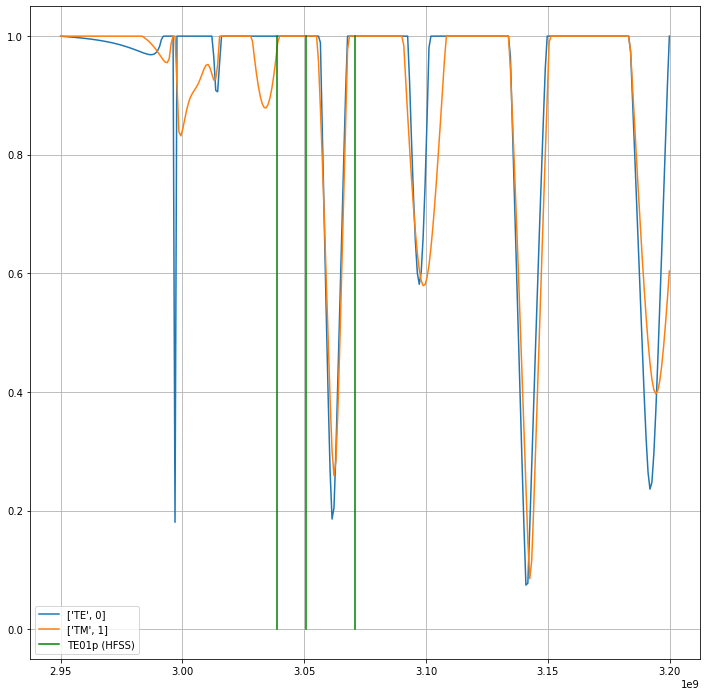

In [55]:
fig4, ax4 = plt.subplots(figsize=(12,12))

for i,H in enumerate(vary):
    # if i<1: continue
    # if i>0: continue
    # ees = [np.abs(max(e)) for e in e_vals[i]]
    ees = [min(np.abs(e)) for e in e_vals[i]]
    # ees = [np.abs(e[0]) for e in e_vals[i]]
    # print(ees)
    # if i==2:
    ax4.plot( (omegas/2/np.pi) + .0, ees, label="{}".format(H)) # .047e9
    
te011 = 3.038816e9
te012 = 3.050787e9
te013 = 3.0708643e9
ax4.plot(len(omegas)*[te011], np.linspace(0, 1, len(omegas)), label='TE01p (HFSS)', color='green')
ax4.plot(len(omegas)*[te012], np.linspace(0, 1, len(omegas)), color='green')
ax4.plot(len(omegas)*[te013], np.linspace(0, 1, len(omegas)), color='green')

# ax4.set_yscale('log')
ax4.legend()
ax4.grid(which='both')
# ax4.get_xticklabels()[0].set_fontsize(24)
# ax4.set_ylim(0,1.5)
# ax4.set_xlim(2.98e9, 3.1e9)

In [87]:
# int_TRmR_x_TLmL(T_modeL=grov_section, T_modeR=smot_section, n=0, mL=1, mR=1)
# print(int_TRmR_x_TLmL(T_modeL=grov_section, T_modeR=smot_section, n=0, mL=2, mR=2))
# print(int_Tm_x_Tm(grov_section, n, 2, R=min(grov_section.a, smot_section.a)))

print(coeff_TRmR_x_TLmL(om, grov_section, smot_section, 0, 2, 2))
print(coeff_Tm_x_Tm(om, grov_section, 0, 2))

[0.-1.32092271e-02j 0.+1.67842460e+02j]
[0.-1.43141376e-02j 0.+1.74721249e+02j]


In [98]:
print(quad(lambda r: 2*np.pi*r*special.jvp(0,smot_section.kc(0,1)*r)*special.jvp(0,smot_section.kc(0,2)*r), 
     a=1e-8, b=smot_section.a, epsabs = 1.49e-9, epsrel=1.49e-8))
print(quad(lambda r: 2*np.pi*r*special.jvp(0,smot_section.kc(0,2)*r)*special.jvp(0,grov_section.kc(0,2)*r), 
     a=1e-8, b=smot_section.a, epsabs = 1.49e-11, epsrel=1.49e-8))
print(quad(lambda r: 2*np.pi*r*special.jvp(0,smot_section.kc(0,3)*r)*special.jvp(0,grov_section.kc(0,3)*r), 
     a=1e-8, b=smot_section.a, epsabs = 1.49e-11, epsrel=1.49e-8))

(-2.6454528671837617e-20, 7.601303844655818e-15)
(0.0010821697482226045, 4.053588337883752e-12)
(0.0007386416423772063, 4.542055758020269e-16)


In [56]:
# (0.15143109680583128-0j) (-0+0.023000439552071174j) 
# [0.-1.43141376e-02j 0.+1.74721249e+02j] 
# [0.-1.65976606e-02j 0.+6.54894828e+01j] 
# [0.-4.42813696e-02j 0.+3.07307850e+02j]

t1 = np.array([0.-1.43141376e-02j, 0.+1.74721249e+02j] )
t2 = np.array([0.-4.42813696e-02j, 0.+3.07307850e+02j])

print(t2@R2[1,0][0])
print(t1@R2[1,0][1])
print(t2@R2[1,0][0] / t1@R2[1,0][1])

-0.03012854919738996j
-0.19895879915754514j
(1.963585964238896e-07+0j)


### Plot resonant fields

In [ ]:
w_res = omegas[np.argmax(s_vals)]

In [ ]:
rpts = np.linspace(-a,a,2)
ypts = np.linspace(-a,a,1000)
zpts = np.linspace(0, fL, 1000)

In [ ]:
fig21 = plt.figure((1,3),figsize=(10,10))